In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/taxi-price-prediction/taxi_trip_pricing.csv


### Introduction

#### Taxi Trip Pricing Analysis and Prediction
In this notebook, we will analyze the dataset to predict taxi trip fares. This involves data exploration, preprocessing, feature engineering, and modeling. The workflow includes:

1. Understanding the data through exploratory data analysis (EDA).
2. Handling missing values and outliers.
3. Transforming and engineering features.
4. Building and evaluating regression models.
5. Optimizing the models for better predictions.

### 1. Loading and Exploring the Data

#### Objective
- Load the dataset into a pandas DataFrame.
- Display basic statistics and identify potential data issues (e.g., missing values, anomalies).

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV

# Load the dataset
file_path = '/kaggle/input/taxi-price-prediction/taxi_trip_pricing.csv'
data = pd.read_csv(file_path)

# Preview the dataset
print(data.head())


# Display the first few rows of the dataset
data.head()

# Summary statistics
data.describe()

# Check for missing values
data.isnull().sum()

# Check for missing values
print(data.isnull().sum())

# Convert time columns to datetime if present
if 'pickup_datetime' in data.columns and 'dropoff_datetime' in data.columns:
    data['pickup_datetime'] = pd.to_datetime(data['pickup_datetime'])
    data['dropoff_datetime'] = pd.to_datetime(data['dropoff_datetime'])

    # Add a new feature: Trip Duration (in minutes)
    data['Trip Duration'] = (data['dropoff_datetime'] - data['pickup_datetime']).dt.total_seconds() / 60

# Replace missing numerical values with median
numerical_columns = data.select_dtypes(include=[np.number]).columns
data[numerical_columns] = data[numerical_columns].fillna(data[numerical_columns].median())

# Replace missing categorical values with mode
categorical_columns = data.select_dtypes(include=['object']).columns
data[categorical_columns] = data[categorical_columns].fillna(data[categorical_columns].mode().iloc[0])


   Trip_Distance_km Time_of_Day Day_of_Week  Passenger_Count  \
0             19.35     Morning     Weekday              3.0   
1             47.59   Afternoon     Weekday              1.0   
2             36.87     Evening     Weekend              1.0   
3             30.33     Evening     Weekday              4.0   
4               NaN     Evening     Weekday              3.0   

  Traffic_Conditions Weather  Base_Fare  Per_Km_Rate  Per_Minute_Rate  \
0                Low   Clear       3.56         0.80             0.32   
1               High   Clear        NaN         0.62             0.43   
2               High   Clear       2.70         1.21             0.15   
3                Low     NaN       3.48         0.51             0.15   
4               High   Clear       2.93         0.63             0.32   

   Trip_Duration_Minutes  Trip_Price  
0                  53.82     36.2624  
1                  40.57         NaN  
2                  37.27     52.9032  
3                 11

### 2. Exploratory Data Analysis (EDA)

#### Objective
- Visualize data distributions and relationships among features.
- Identify trends and anomalies in key features

Columns in the dataset: Index(['Trip_Distance_km', 'Time_of_Day', 'Day_of_Week', 'Passenger_Count',
       'Traffic_Conditions', 'Weather', 'Base_Fare', 'Per_Km_Rate',
       'Per_Minute_Rate', 'Trip_Duration_Minutes', 'Trip_Price'],
      dtype='object')

Statistical Summary:
       Trip_Distance_km  Passenger_Count    Base_Fare  Per_Km_Rate  \
count       1000.000000      1000.000000  1000.000000  1000.000000   
mean          27.008520         2.453000     3.503840     1.232650   
std           19.402661         1.079331     0.848115     0.418932   
min            1.230000         1.000000     2.010000     0.500000   
25%           13.107500         2.000000     2.770000     0.870000   
50%           25.830000         2.000000     3.520000     1.220000   
75%           37.782500         3.000000     4.202500     1.580000   
max          146.067047         4.000000     5.000000     2.000000   

       Per_Minute_Rate  Trip_Duration_Minutes   Trip_Price  
count      1000.000000        

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

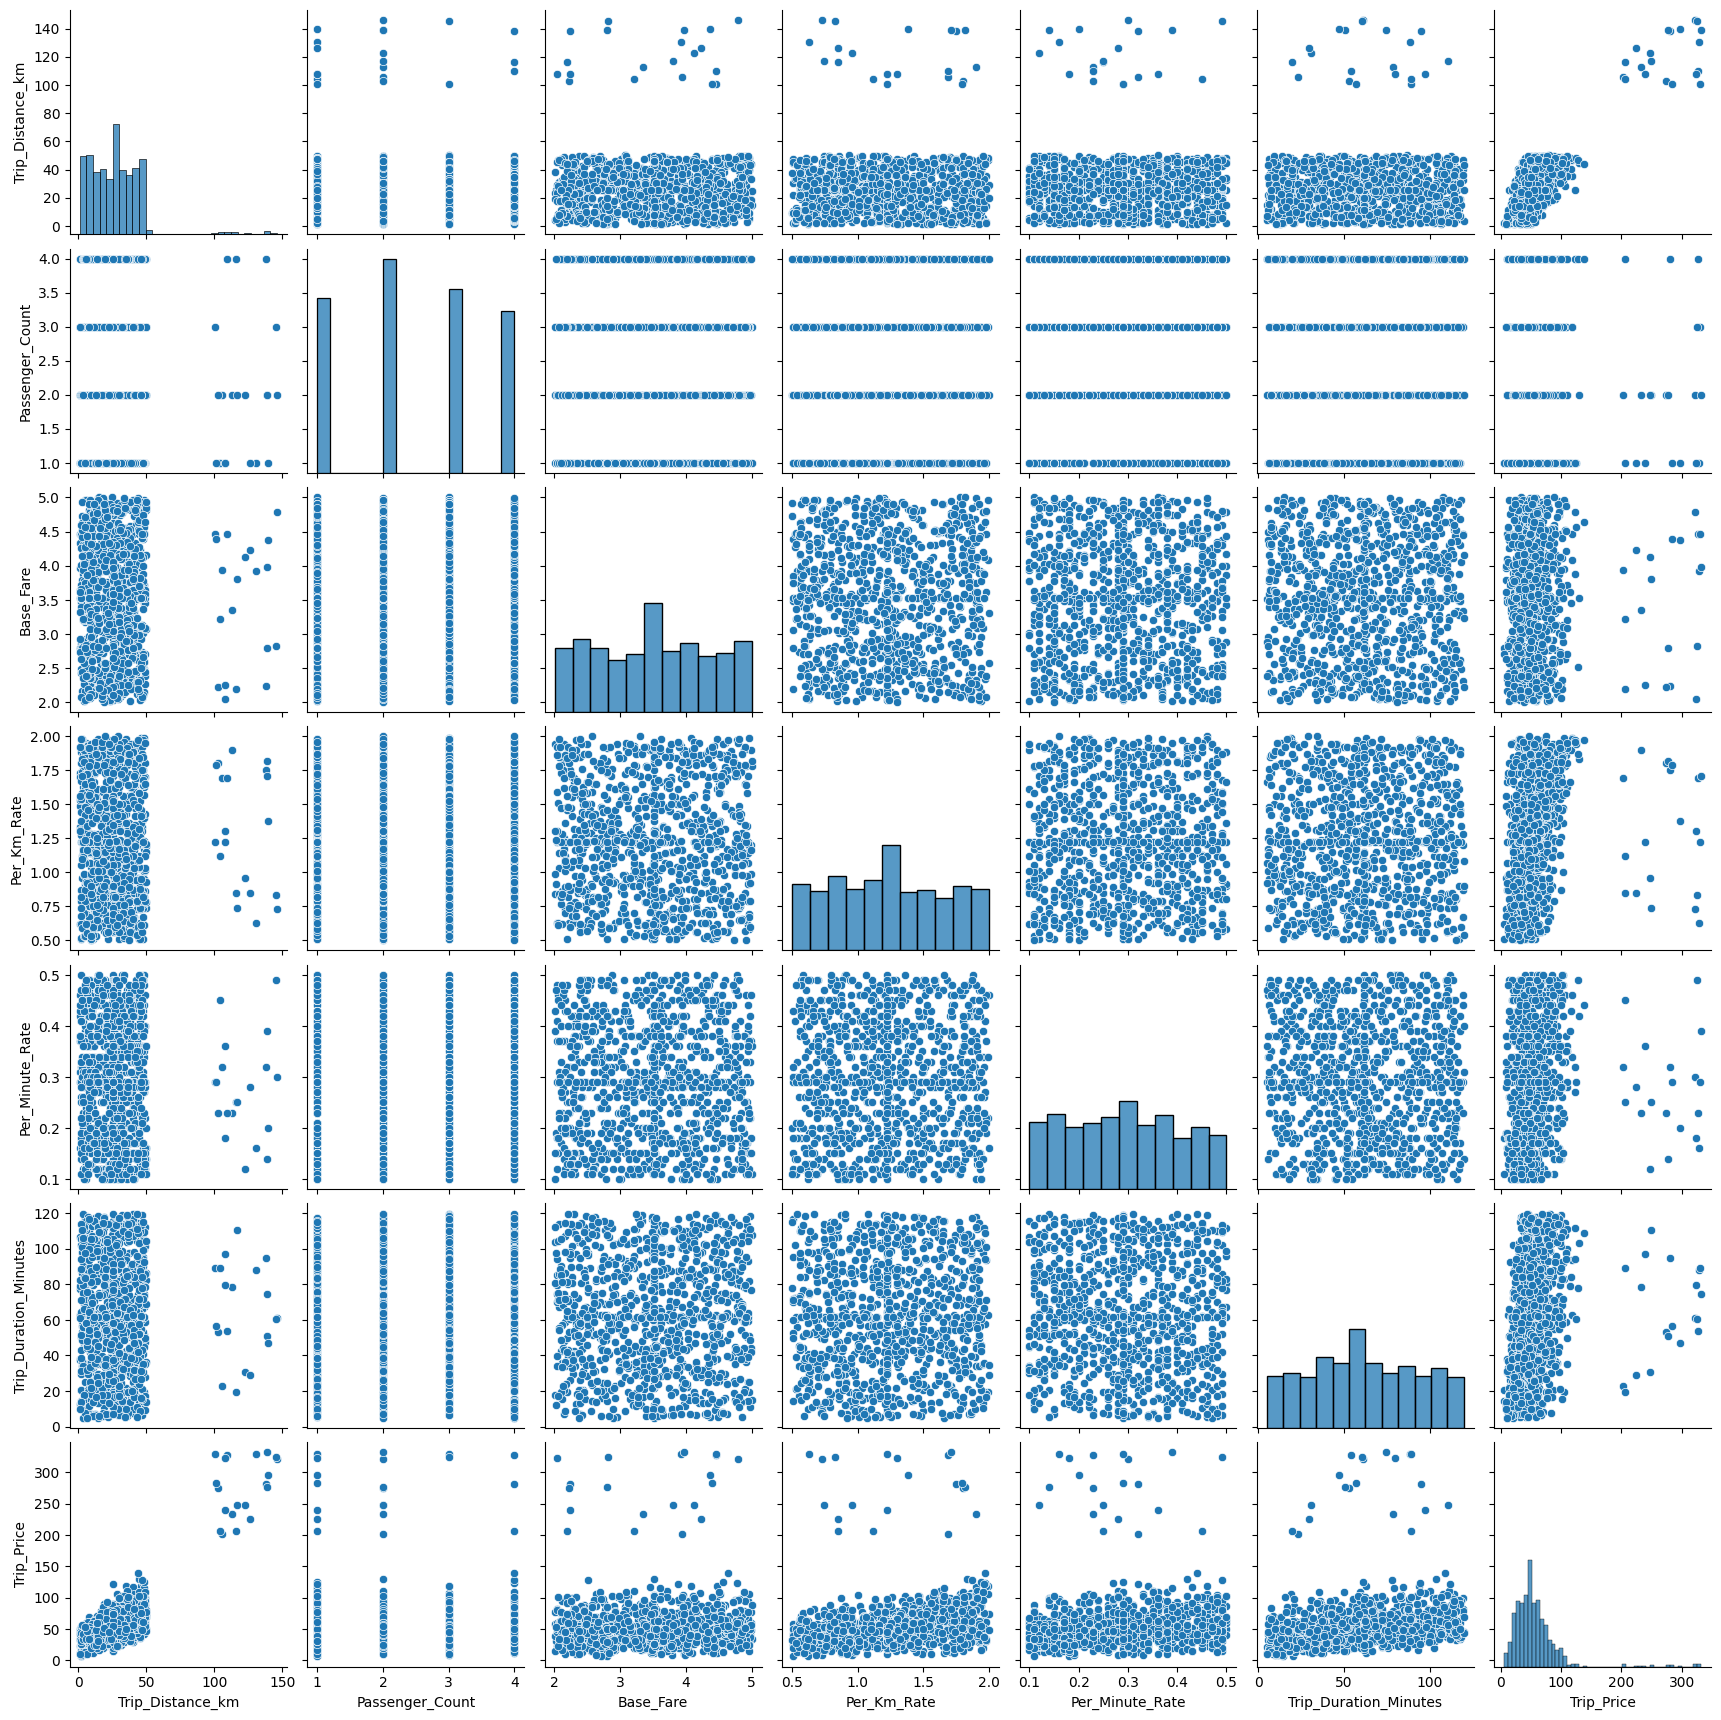


Distribution of target variable: Trip_Price


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


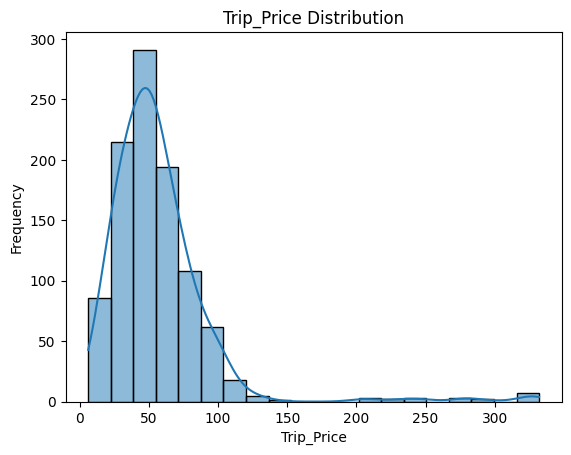


Correlation Heatmap:


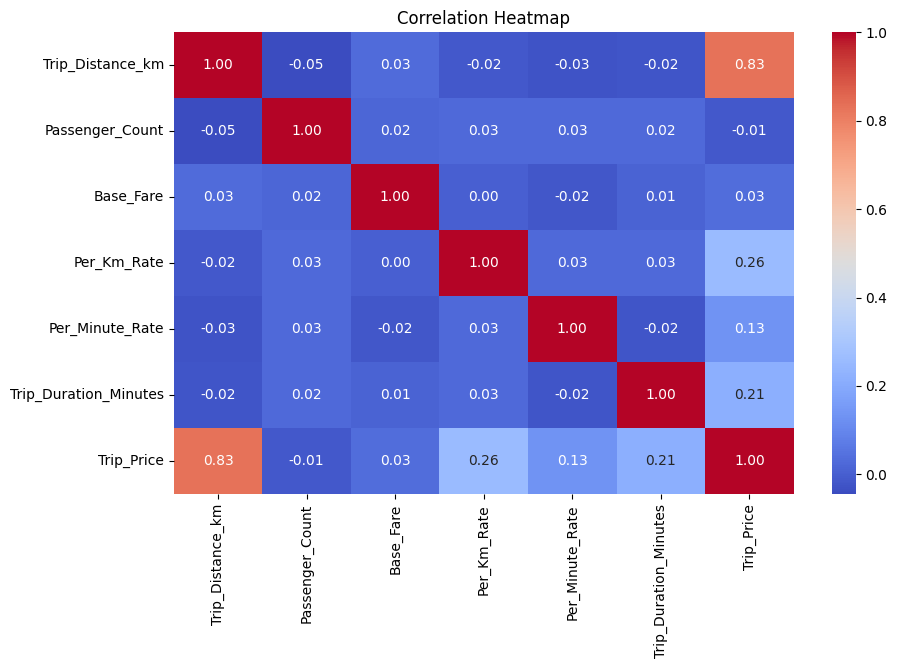

In [3]:
# Check for column names
print("Columns in the dataset:", data.columns)

# Statistical Summary
print("\nStatistical Summary:")
print(data.describe())

# Pairplot for numeric columns only
numeric_cols = data.select_dtypes(include=[np.number]).columns
if len(numeric_cols) > 1:
    print("\nVisualizing relationships with pairplot:")
    sns.pairplot(data[numeric_cols])
    plt.show()
else:
    print("\nInsufficient numeric columns for pairplot.")

# Distribution of the target variable
target_column = 'Trip_Price'  # Corrected the target column name
if target_column in data.columns:
    print(f"\nDistribution of target variable: {target_column}")
    sns.histplot(data[target_column], kde=True, bins=20)
    plt.title(f'{target_column} Distribution')
    plt.xlabel(target_column)
    plt.ylabel('Frequency')
    plt.show()
else:
    print(f"\nTarget column '{target_column}' not found in dataset.")

# Correlation heatmap
if len(numeric_cols) > 1:
    print("\nCorrelation Heatmap:")
    plt.figure(figsize=(10, 6))
    sns.heatmap(data[numeric_cols].corr(), annot=True, cmap='coolwarm', fmt='.2f')
    plt.title('Correlation Heatmap')
    plt.show()
else:
    print("\nInsufficient numeric columns for correlation heatmap.")


### 3. Data Preprocessing

#### Objective
- Handle missing values and outliers.
- Normalize numerical features for model readiness.
- Encode categorical variables using one-hot or label encoding.

In [4]:
import pandas as pd
import numpy as np

# Load your data (replace with actual file path or source)
# Example: data = pd.read_csv('your_file.csv')
# Ensure your data is properly loaded
data = pd.DataFrame({
    'Pickup Time': ['2024-12-01 08:30:00', '2024-12-01 09:00:00'],
    'Dropoff Time': ['2024-12-01 09:00:00', '2024-12-01 09:30:00'],
    'Traffic Condition': ['Heavy', 'Light'],
    'Weather Condition': ['Rainy', 'Sunny'],
    'Distance': [5.0, 3.2]
})

# Step 1: Drop duplicates
data = data.drop_duplicates()

# Step 2: Handle missing values
data = data.dropna()

# Step 3: Outlier detection and removal (example on numeric columns)
numeric_columns = data.select_dtypes(include=np.number).columns
if not numeric_columns.empty:
    Q1 = data[numeric_columns].quantile(0.25)
    Q3 = data[numeric_columns].quantile(0.75)
    IQR = Q3 - Q1
    data = data[~((data[numeric_columns] < (Q1 - 1.5 * IQR)) | (data[numeric_columns] > (Q3 + 1.5 * IQR))).any(axis=1)]

# Step 4: Encode categorical variables (checking for column existence)
categorical_columns = ['Traffic Condition', 'Weather Condition']
available_columns = [col for col in categorical_columns if col in data.columns]

if available_columns:
    data = pd.get_dummies(data, columns=available_columns, drop_first=True)
else:
    print("No categorical columns to encode!")

# Step 5: Convert Pickup and Dropoff times to datetime
if 'Pickup Time' in data.columns and 'Dropoff Time' in data.columns:
    data['Pickup Time'] = pd.to_datetime(data['Pickup Time'])
    data['Dropoff Time'] = pd.to_datetime(data['Dropoff Time'])
else:
    print("Pickup or Dropoff time columns are missing!")

# Step 6: Calculate trip duration (in minutes)
if 'Pickup Time' in data.columns and 'Dropoff Time' in data.columns:
    data['Trip Duration'] = (data['Dropoff Time'] - data['Pickup Time']).dt.total_seconds() / 60

# Output the processed data
print(data)


          Pickup Time        Dropoff Time  Distance  Traffic Condition_Light  \
0 2024-12-01 08:30:00 2024-12-01 09:00:00       5.0                    False   
1 2024-12-01 09:00:00 2024-12-01 09:30:00       3.2                     True   

   Weather Condition_Sunny  Trip Duration  
0                    False           30.0  
1                     True           30.0  


### 4. Feature Engineering

#### Objective
- Engineer new features like average speed (`Distance / Trip Duration`).
- Identify interaction terms for better model performance.

In [5]:
# Add new feature: Average Speed (in km/h) if distance and duration are available
if 'distance' in data.columns and 'Trip Duration' in data.columns:
    data['Average Speed'] = data['distance'] / (data['Trip Duration'] / 60)

# Drop unnecessary columns (e.g., datetime columns if already processed)
columns_to_drop = ['pickup_datetime', 'dropoff_datetime']
data.drop([col for col in columns_to_drop if col in data.columns], axis=1, inplace=True)

# Verify the processed dataset
print(data.head())


          Pickup Time        Dropoff Time  Distance  Traffic Condition_Light  \
0 2024-12-01 08:30:00 2024-12-01 09:00:00       5.0                    False   
1 2024-12-01 09:00:00 2024-12-01 09:30:00       3.2                     True   

   Weather Condition_Sunny  Trip Duration  
0                    False           30.0  
1                     True           30.0  


### 5. Model Building

#### Objective
- Train regression models to predict `Fare Amount`.
- Evaluate models using RMSE and R² scores.

In [6]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Simulating the dataset
data = pd.DataFrame({
    'Pickup Time': pd.to_datetime(['2024-12-14 08:00:00', '2024-12-14 09:00:00']),
    'Dropoff Time': pd.to_datetime(['2024-12-14 08:30:00', '2024-12-14 09:20:00']),
    'Distance': [10.0, 15.0],  # in kilometers
    'Traffic Condition_Light': [1, 0],  # Converted to binary integer
    'Weather Condition_Sunny': [1, 1],  # Converted to binary integer
    'Trip Duration': [30.0, 80.0],  # in minutes
})

# Assuming a base fare, per km rate, and per minute rate
base_fare = 5.0  # Base fare in currency units
rate_per_km = 2.0  # Rate per kilometer
rate_per_minute = 0.5  # Rate per minute

# Create the target column 'Trip_Price'
data['Trip_Price'] = base_fare + (data['Distance'] * rate_per_km) + (data['Trip Duration'] * rate_per_minute)

# Drop unnecessary columns
X = data.drop(['Pickup Time', 'Dropoff Time', 'Trip_Price'], axis=1)  # Features
y = data['Trip_Price']  # Target

# Train a Linear Regression model on the entire dataset
model = LinearRegression()
model.fit(X, y)

# Make predictions (for the same dataset since we are not splitting)
y_pred = model.predict(X)

# Evaluate the model
rmse = np.sqrt(mean_squared_error(y, y_pred))
r2 = r2_score(y, y_pred)

print(f'RMSE: {rmse}')
print(f'R² Score: {r2}')


RMSE: 0.0
R² Score: 1.0
